# Memory Efficient Kernel Approximation

In [1]:
import numpy as np
import pandas as pd
import cvxpy
import matplotlib.pyplot as plt
import time
%matplotlib inline

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.gaussian_process.kernels import RBF
from sklearn.cluster import KMeans

from numpy.linalg import pinv
from numpy.linalg import inv
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import choice

from scipy.sparse.linalg import svds

from itertools import permutations

#### Données

In [ ]:
data = pd.read_csv('/Users/julien/Downloads/ijcnn1.csv', header=None).values
print(data.shape)
data = data[np.random.choice(data.shape[0], 10000, replace=False),:]
data.shape

#### Fonctions

In [ ]:
def Kernel_matrix(gamma, X):
    kernel = RBF(1/np.sqrt(2*gamma))
    G = pairwise_kernels(X, metric=kernel, filter_params=False)
    return G

In [2]:
def cluster_indices(cluster, cluster_counts):
    cluster_end = cluster_counts[cluster] # begining of indices of the cluster 
    if cluster == list(cluster_counts.keys())[0]:
        cluster_start = 0 # end 
    else:
        cluster_start = cluster_counts[cluster-1] #end 
    cluster_ids = np.arange(cluster_start, cluster_end) #indices
    return cluster_ids

In [199]:
def nystrom(gamma, X, k, m, rs=0, approx=False):
    kernel = RBF(1/np.sqrt(2*gamma))
    #m = X.shape[0]  // 25
    #m = 12
    idx_select = choice(np.arange(X.shape[0]), size=m, replace=False) # random sample of columns to select
    X_sample = X[idx_select, :] # data points  
    C = pairwise_kernels(X, Y=X_sample, metric=kernel, filter_params=False) # sampled colunms of kernel matric
    M = C[idx_select, :] # Kernel matrix of the sampled data
    U, s, V = svds(M, k) # rank-k approximation
    S = np.diag(s)
    M_k = np.dot(U, np.dot(S,V))
    M_kpinv = pinv(M_k)
    if approx:
        return np.dot(C, np.dot(M_kpinv, np.transpose(C)))
    else:
        return C, M_kpinv

In [264]:
def MEKA(gamma, X, k, c, rs=0, verbose=False):
    Gbar = np.zeros((X.shape[0], X.shape[0]))
    kernel = RBF(1/np.sqrt(2*gamma)) # define kernel 
    kmeans = KMeans(c, random_state=rs) # Define clustering operator 
    if verbose:
        print('\nClustering.....')
    clusters = kmeans.fit_predict(X) # compute clusters 
    unique, counts = np.unique(clusters, return_counts=True) # count nb of points in clusters
    counts = np.cumsum(counts)
    cluster_counts = dict(zip(unique, counts))
    new_idx = np.argsort(clusters)
    reverse_idx = np.argsort(new_idx)
    X = X[new_idx,:] # rearenging matrix
    W = {} # dict for W matrices of nystrom approximation
    # diagonal blocs aproximation
    if verbose:
        print('Diagonal blocks aproximation...')
    for s in list(cluster_counts.keys()):
        print ('#'*s + '.'*(c-1-s) +'\r', end='')
        s_ids = cluster_indices(s, cluster_counts) # define indicies for selection
        X_ss = X[s_ids, :] # Data selection
        W[s], L_ss = nystrom(gamma, X_ss, k, k+1) # Low-rank approx
        Gbar[np.ix_(s_ids, s_ids)] = np.dot(W[s], np.dot(L_ss, np.transpose(W[s])))
        #print(np.dot(W[s], np.dot(L_ss, np.transpose(W[s]))))
    # Non diagonoals block approximation
    if verbose:
        print('\nNon diagonals blocks approximation...')
    i = 0
    for s,t in permutations(list(cluster_counts.keys()), 2):
        if verbose:
            print ('#'*i + '.'*(len(list(permutations(list(cluster_counts.keys()), 2)))-1-i) +'\r', end='')
        i += 1
        # indices of clusters points
        s_ids = cluster_indices(s, cluster_counts)
        t_ids = cluster_indices(t, cluster_counts)
        # Sampling columns and rows
        vs = choice(np.arange(s_ids.shape[0]), replace=False, size=3*k)
        vt = choice(np.arange(t_ids.shape[0]), replace=False, size=3*k)
        # Sampling data 
        X_s = X[s_ids[vs], :]
        X_t = X[t_ids[vt], :]
        # Computing associated Kernel Matrix
        Ghat_st = pairwise_kernels(X_s, Y=X_t, # restriction of kernel matrix
                                   metric=kernel, filter_params=False)
        # Sampling transformation matrixes
        W_s_vs = W[s][vs,:]
        W_t_vt = W[t][vt,:]
        # Computing L_st
        L_st = inv(np.transpose(W_s_vs).dot(W_s_vs)).dot(
            np.transpose(W_s_vs)).dot(
            Ghat_st).dot(W_t_vt).dot(
            inv(np.transpose(W_t_vt).dot(
                W_t_vt)))
        L_st = lst(W_s_vs, W_t_vt, Ghat_st)
        # Compute Gbar_st
        Gbar[np.ix_(s_ids, t_ids)] = np.dot(np.dot(W[s],L_st),np.transpose(W[t]))
    return Gbar[np.ix_(reverse_idx, reverse_idx)]

In [189]:
def approx_error(G, Gbar):
    return norm(G-Gbar, ord='fro')/norm(G, ord='fro')

#### Evolution des résultats de la méthode de Nystrom en fonction du rang à approximer

//anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


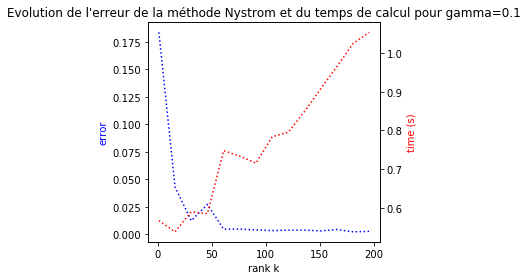

In [280]:
N_error, N_time = [], []
step = 15
niter = 200
gamma=0.1
G = Kernel_matrix(gamma, data)
for k in range(1, niter, step):
    print('k = ' + str(k) + '\r' , end='')
    start = time.time()
    w, cplus = nystrom(gamma, data, k, k+1)
    Gn = np.dot(np.dot(w, cplus), w.transpose())
    N_time.append(time.time() - start)
    N_error.append(approx_error(G, Gn))

fig, ax1 = plt.subplots()
xs = [k for k in range(1, niter, step)]
ax1.plot(xs, N_error, ":b")
ax1.set_xlabel('rank k')
ax1.set_ylabel('error', color="b")
ax1.tick_params('y')

ax2 = ax1.twinx()
ax2.plot(xs, N_time, ':r')
ax2.set_ylabel('time (s)', color='r')
ax2.tick_params('y')

plt.title('Evolution de l\'erreur de la méthode Nystrom et du temps de calcul pour gamma={}'.format(gamma))
fig.tight_layout()
fig.savefig('Nystrom.png', dpi=300)
fig.show()

#### Evolution de l'erreur en fonction du rang d'approximation

//anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


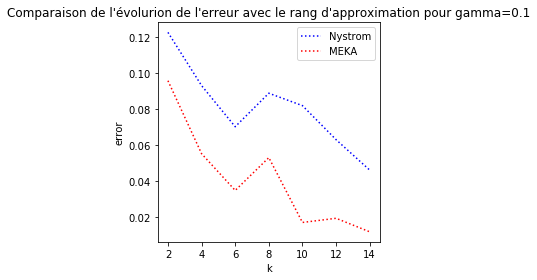

In [279]:
MEKA_error, N_error =  [], [] 
gamma = 0.1
final_k = 15
step = 2
G = Kernel_matrix(gamma, data)
for k in np.arange(2, final_k, step):
    w, cplus = nystrom(gamma, data, k, k+1)
    Gn = np.dot(np.dot(w, cplus), w.transpose())
    N_error.append(approx_error(G, Gn))
    Gt = MEKA(gamma, data, k, 10)
    MEKA_error.append(approx_error(G, Gt))
    
fig, ax1 = plt.subplots()
xs = [k for k in range(2, final_k, step)]
ax1.plot(xs, N_error, ":b", label='Nystrom')
ax1.plot(xs, MEKA_error, ":r", label='MEKA')
ax1.set_xlabel('rank k')
ax1.set_ylabel('error')
ax1.tick_params('y')

plt.legend()
plt.title('Comparaison de l\'évolurion de l\'erreur avec le rang d\'approximation pour gamma={}'.format(gamma))
fig.tight_layout()
fig.savefig('rank.png', dpi=400)
fig.show()

#### Evolution de l'erreur en fonciton de gamma

//anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


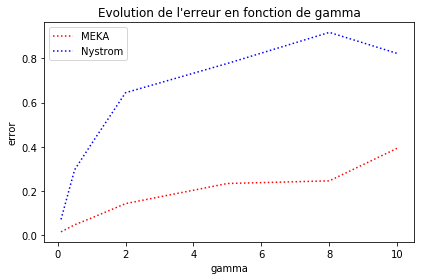

In [283]:
MEKA_error, N_error =  [], [] 
k=15
gammas = [0.1, 0.5, 1, 2, 5, 8, 10]
for gamma in gammas:
    G = Kernel_matrix(gamma, data)
    w, cplus = nystrom(gamma, data, k, k+1)
    Gn = np.dot(np.dot(w, cplus), w.transpose())
    N_error.append(approx_error(G, Gn))
    Gt = MEKA(gamma, data, k, 10)
    MEKA_error.append(approx_error(G, Gt))



fig, ax1 = plt.subplots()
ax1.plot(gammas, MEKA_error, ":r", label='MEKA')
ax1.plot(gammas, N_error, ":b", label='Nystrom')
ax1.set_xlabel('gamma')
ax1.set_ylabel('error')
ax1.tick_params('y')

plt.legend()
plt.title('Evolution de l\'erreur en fonction de gamma')
fig.tight_layout()
fig.savefig('gammas.png', dpi=400)
fig.show()